# Dependencies

- Sci-kit learn
- NumPy 
- SciPy

`utils.py` contains misc. utilitaries such as measures and task dictionaries, confusion matrix.

In [1]:
#visualization
import matplotlib.pyplot as plt

#math tools
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import resample
from scipy.signal import decimate

#stat tools
from scipy.stats import pearsonr#2 continuous variable
from scipy.stats import spearmanr#1 binary and 1 continuous variable
from scipy.stats import ttest_ind
from scipy.stats import bartlett
from scipy.stats import shapiro
#utils
from time import time
from os.path import join
from os import listdir
#custom
from modules.utils import *
from modules.load_data import *

#machine learning
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split


# Data
## Downloading

To get access to the PaHaW database
Please	 fill	 in	 a	 license	 agreement	 that	 can	 be	 downloaded	 in	 DOCX	 or	 PDF	 (see http://bdalab.utko.feec.vutbr.cz/)	 and	 send	 it	 to	 mekyska@feec.vutbr.cz	 with	 CC	 to	peter.drotar@tuke.sk	 and	 irena.rektorova@fnusa.cz.	 You	 will	 consequently	 get	 an	 access	 to	 the	database.

The data should be placed like this :  
```
data
└───PaHaW
│   └───PaHaW_public
│   │   │   000**
│   │   corpus_PaHaW.xlsx
│   │   corpus_PaHaW.csv
```

**`corpus_PaHaW.csv` doesn't exist in the database, you should create it by opening `corpus_PaHaW.xlsx` (with e.g. LibreOffice Calc or Microsoft Excel) then `File, Save as, corpus_PaHaW.csv` (the separator should be `;`).**
## Loading

is done in `load_data.py`. The load_data function yields subjects data, label (1 for PD 0 for control) and age. Note that it discards the subjects who didn't perform the spiral, i.e. Subjects 46 (control), 60 (PD) and 66 (control), counting from zero. Moreover, it trims the data for the few subjects who begin their exam in-air and the one where there is a measure error at the end, see [Data Exploration](#Data-Exploration). The raw data is then turned into a list below.


In [2]:

print("\nloading and massaging data, this might take a few seconds...")
data_gen=load_data()
data,targets,ages=[],[],[]
for subject,label,age in data_gen:
    data.append(subject)
    targets.append(label)
    ages.append(age)
print("(75-3 subjects, 8 tasks, X timesteps, 7 measures)")
print(len(data),len(data[0]),len(data[0][0]),len(data[0][0][0]))


loading and massaging data, this might take a few seconds...
(75-3 subjects, 8 tasks, X timesteps, 7 measures)
72 8 1772 7


# Age and duration analysis
this study is similar to the one in `newhandpd.ipynb`.  
The first part consists in classification of subjects depending on the duration of their different task, and of their age (using either a rule based model or Linear discriminant analysis).

The second part consists of a statistical analysis :
- correlation between the subject's age and it's different tasks' duration
- t-tests between the different tasks durations of controls and PDs
- t-test between the controls and PDs' age

In [3]:
patients_ages,control_ages=[],[]
patients_lengths,control_lengths=[],[]
patients_time,control_time=[],[]
patients_index,control_index=[],[]
for i,age in enumerate(ages):
    if targets[i]==1:
        patients_ages.append(age)
        patients_lengths.append([len(task) for task in data[i]])
        patients_time.append([task[-1][2]-task[0][2] for task in data[i]])
        patients_index.append(i)
    else:
        control_ages.append(age)
        control_lengths.append([len(task) for task in data[i]])
        control_time.append([task[-1][2]-task[0][2] for task in data[i]])
        control_index.append(i)
patients_lengths,control_lengths=np.asarray(patients_lengths),np.asarray(control_lengths)
patients_time,control_time=np.asarray(patients_time),np.asarray(control_time)

The timestamp measure of the first subject's spiral doesn't contain any pauses so we use it to convert the time stamp to ms.

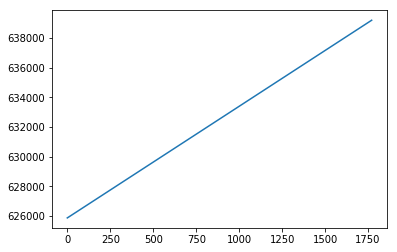

In [4]:
plt.plot(np.asarray(data[0][0])[:,2])

In [5]:
print("len(data[0][0])*1000/150 :",len(data[0][0])*1000/150)
print("we divide by 150 because it's the sampling rate and multiply by 1000 to get ms.")
print("t_n - t_0 :",data[0][0][-1][2]-data[0][0][0][2])
time_factor=(data[0][0][-1][2]-data[0][0][0][2])/(len(data[0][0])*1000/150)
print("so we can can conclude that there's a factor of {} between the time stamp and ms".format(
time_factor))
control_time/=time_factor
patients_time/=time_factor
times=np.concatenate((patients_time,control_time),axis=0)
times.shape

median=np.median(np.mean(times,axis=1))

medians=np.median(times,axis=0)

len(data[0][0])*1000/150 : 11813.333333333334
we divide by 150 because it's the sampling rate and multiply by 1000 to get ms.
t_n - t_0 : 13310.0
so we can can conclude that there's a factor of 1.1266930022573363 between the time stamp and ms


So we have divide the task time by `1.127` in order to get ms.
See below how the plots of time and length are then merged into one, except on some subjects that did pause (see `DetectPause`)

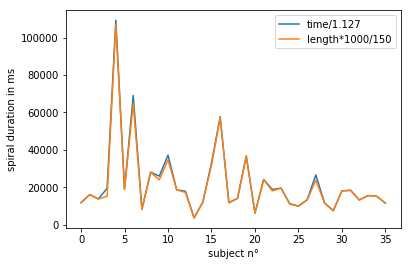

In [7]:
plt.xlabel("subject n°")
plt.ylabel("spiral duration in ms")
plt.plot(patients_time[:,0],label="time/1.127")
plt.plot(patients_lengths[:,0]*1000/150,label="length*1000/150")
plt.legend()

In [16]:
def rule_based(threshold,patients_lengths,control_lengths):
    tp=len([i for i in patients_lengths if i >threshold])
    fp=len(patients_lengths)-tp

    tn=len([i for i in control_lengths if i <=threshold])
    fn=len(control_lengths)-tn
    accuracy,sensitivity,specificity,ppv,npv=return_metrics(tp,tn,fp,fn)
    results=""
    for metric in [accuracy,sensitivity,specificity,ppv,npv]:
        results+=" | {:.2f}".format(metric)
    print(results)

## Classification


In [17]:
for i,task in enumerate(index2task):
    print(task,end="")
    rule_based(medians[i],patients_time[:,0],control_time[:,0])

spiral | 0.53 | 0.53 | 0.53 | 0.53 | 0.53
l | 0.56 | 0.53 | 0.64 | 0.86 | 0.25
le | 0.53 | 0.52 | 0.54 | 0.69 | 0.36
les | 0.56 | 0.55 | 0.56 | 0.58 | 0.53
lektorka | 0.54 | 0.54 | 0.54 | 0.56 | 0.53
porovnat | 0.53 | 0.52 | 0.53 | 0.61 | 0.44
nepopadnout | 0.50 | 0.50 | 0.50 | 0.89 | 0.11
tram | 0.51 | 0.53 | 0.51 | 0.28 | 0.75


### when setting threshold at median(subjects_lengths)



task|Accuracy|Se | Sp | PPV | NPV
--|--|--|--|--|--
spiral | 0.53 | 0.53 | 0.53 | 0.53 | 0.53
l | 0.56 | 0.53 | 0.64 | 0.86 | 0.25
le | 0.53 | 0.52 | 0.54 | 0.69 | 0.36
les | 0.56 | 0.55 | 0.56 | 0.58 | 0.53
lektorka | 0.54 | 0.54 | 0.54 | 0.56 | 0.53
porovnat | 0.53 | 0.52 | 0.53 | 0.61 | 0.44
nepopadnout | 0.50 | 0.50 | 0.50 | 0.89 | 0.11
tram | 0.51 | 0.53 | 0.51 | 0.28 | 0.75
all | 0.58 | 0.58 | 0.58 | 0.58 | 0.58

### with LDA : random 50-50 split with 15 runs

task|Accuracy|Se | Sp | PPV | NPV
--|--|--|--|--|--
spiral | 50.56 ± (6.97) | 38.52 ± (14.27) | 62.59 ± (22.17) | 52.97 ± (9.01) | 48.65 ± (9.00) | 
l | 48.52 ± (7.23) | 50.37 ± (20.23) | 46.67 ± (20.96) | 48.64 ± (7.13) | 48.14 ± (9.38) | 
le | 58.33 ± (6.25) | 48.52 ± (14.27) | 68.15 ± (18.08) | 62.83 ± (9.78) | 56.94 ± (5.96) | 
les | 55.93 ± (3.91) | 44.81 ± (10.24) | 67.04 ± (13.06) | 58.59 ± (6.39) | 54.78 ± (2.83) | 
lektorka | 48.70 ± (6.24) | 40.37 ± (11.01) | 57.04 ± (14.83) | 48.89 ± (6.96) | 48.19 ± (7.21) | 
porovnat | 49.63 ± (6.16) | 41.11 ± (9.69) | 58.15 ± (12.32) | 49.79 ± (6.98) | 49.29 ± (6.55) | 
nepopadnout | 50.19 ± (6.99) | 44.81 ± (11.91) | 55.56 ± (14.49) | 50.46 ± (7.09) | 49.60 ± (8.36) | 
tram | 51.30 ± (5.73) | 42.22 ± (13.88) | 60.37 ± (12.32) | 51.59 ± (7.60) | 51.39 ± (5.11) | 
all | 56.48 ± (4.61) | 52.22 ± (12.80) | 60.74 ± (10.03) | 57.15 ± (5.52) | 56.58 ± (5.09) | 

#### using age as feature 
Accuracy|Se | Sp | PPV | NPV
--|--|--|--|--
63.70 ± (7.49) | 63.33 ± (13.58) | 64.07 ± (10.90) | 63.99 ± (7.82) | 64.48 ± (8.56) | 





## Classification with LinearDiscriminantAnalysis
### Single task assessment

In [24]:


targets=np.asarray([1 for _ in range(36)]+[0 for _ in range( 36)])
for i,task in enumerate(index2task):
    model = LinearDiscriminantAnalysis()
    features=np.asarray(times[:,i])
    skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    #cv_generator=skf.split(features,targets)
    metrics=[]
    for random_state in range(15):
    #for train_index, test_index in cv_generator:
        train_data,test_data,train_targets,test_targets=train_test_split(
            features,targets,test_size=0.5,stratify=targets,random_state=random_state)
        #train_data,test_data=features[train_index],features[test_index]
        #train_targets,test_targets=targets[train_index],targets[test_index]
        model.fit(train_data.reshape(-1,1),train_targets)
        predictions=model.predict(test_data.reshape(-1,1))
        tn, fp, fn, tp, _ = confusion_matrix(y_true=test_targets,y_pred=predictions)
        accuracy,sensitivity,specificity,ppv,npv=return_metrics(tp,tn,fp,fn)
        metrics.append([accuracy,sensitivity,specificity,ppv,npv])
    print(task,end=" | ")
    for m,s in list(zip(np.mean(metrics,axis=0)*100,np.std(metrics,axis=0)*100)):
        print("{:.2f} ± ({:.2f})".format(m,s),end=" | ")
    print()

spiral | 50.56 ± (6.97) | 38.52 ± (14.27) | 62.59 ± (22.17) | 52.97 ± (9.01) | 48.65 ± (9.00) | 
l | 48.52 ± (7.23) | 50.37 ± (20.23) | 46.67 ± (20.96) | 48.64 ± (7.13) | 48.14 ± (9.38) | 
le | 58.33 ± (6.25) | 48.52 ± (14.27) | 68.15 ± (18.08) | 62.83 ± (9.78) | 56.94 ± (5.96) | 
les | 55.93 ± (3.91) | 44.81 ± (10.24) | 67.04 ± (13.06) | 58.59 ± (6.39) | 54.78 ± (2.83) | 
lektorka | 48.70 ± (6.24) | 40.37 ± (11.01) | 57.04 ± (14.83) | 48.89 ± (6.96) | 48.19 ± (7.21) | 
porovnat | 49.63 ± (6.16) | 41.11 ± (9.69) | 58.15 ± (12.32) | 49.79 ± (6.98) | 49.29 ± (6.55) | 
nepopadnout | 50.19 ± (6.99) | 44.81 ± (11.91) | 55.56 ± (14.49) | 50.46 ± (7.09) | 49.60 ± (8.36) | 
tram | 51.30 ± (5.73) | 42.22 ± (13.88) | 60.37 ± (12.32) | 51.59 ± (7.60) | 51.39 ± (5.11) | 


### Average over some features
choose with `features = ...`

In [404]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from utils import confusion_matrix,return_metrics

targets=np.asarray([1 for _ in range(36)]+[0 for _ in range( 36)])
model = LinearDiscriminantAnalysis()
features=np.concatenate((patients_ages,control_ages),axis=0).reshape(-1,1)#np.mean(times,axis=1).reshape(-1,1)
skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
cv_generator=skf.split(features,targets)
metrics=[]
for random_state in range(15):
#for train_index, test_index in cv_generator:
    train_data,test_data,train_targets,test_targets=train_test_split(
        features,targets,test_size=0.5,stratify=targets,random_state=random_state)
    #train_data,test_data=features[train_index],features[test_index]
    #train_targets,test_targets=targets[train_index],targets[test_index]
    model.fit(train_data,train_targets)
    predictions=model.predict(test_data)
    tn, fp, fn, tp, _ = confusion_matrix(y_true=test_targets,y_pred=predictions)
    accuracy,sensitivity,specificity,ppv,npv=return_metrics(tp,tn,fp,fn)
    metrics.append([accuracy,sensitivity,specificity,ppv,npv])
for m,s in list(zip(np.mean(metrics,axis=0)*100,np.std(metrics,axis=0)*100)):
    print("{:.2f} ± ({:.2f})".format(m,s),end=" | ")
print()

63.70 ± (7.49) | 63.33 ± (13.58) | 64.07 ± (10.90) | 63.99 ± (7.82) | 64.48 ± (8.56) | 


In [18]:
corr, p = pearsonr(np.mean(times,axis=1),np.concatenate((patients_ages,control_ages),axis=0))
print(" |{:.4f} | {:.4f} ".format(corr, p ))

for i,task in enumerate(index2task):
    print(task,end="")
    corr, p = pearsonr(times[:,i],np.concatenate((patients_ages,control_ages),axis=0))
    print(" |{:.4f} | {:.4f} ".format(corr, p ))

 |0.3631 | 0.0017 
spiral |0.2163 | 0.0681 
l |0.2557 | 0.0301 
le |0.3088 | 0.0083 
les |0.4225 | 0.0002 
lektorka |0.3086 | 0.0084 
porovnat |0.2787 | 0.0178 
nepopadnout |0.2575 | 0.0290 
tram |0.2814 | 0.0166 


## Correlation
### between task duration and subject's age

task | Pearson correlation coefficient | p-value
--|--|--
spiral |0.2163 | 0.0681 
l |0.2557 | 0.0301 
le |0.3088 | 0.0083 
les |0.4225 | 0.0002 
lektorka |0.3086 | 0.0084 
porovnat |0.2787 | 0.0178 
nepopadnout |0.2575 | 0.0290 
tram |0.2814 | 0.0166 
all |0.3631 | 0.0017 

### between task duration and targets
#### t-test

task | t-statistic | t p-value | significance| bartlett statistic | bartlett p-value | patients_shapiro statistic | patients_shapiro  p-value| control_shapiro statistic| control_shapiro p-value
--|--|--|--|--|--|--|--|--|--
spiral |1.5826 | 0.1180 |_ | 23.1519| 1.497e-06| 0.6660| 8.599e-08| 0.8897| 1.808e-03
l |0.1849 | 0.8538 |_ | 0.0450| 8.319e-01| 0.9268| 2.005e-02| 0.8648| 4.253e-04
le |1.3512 | 0.1810 |_ | 2.8645| 9.056e-02| 0.8640| 4.068e-04| 0.8371| 9.749e-05
les |1.4268 | 0.1581 |_ | 7.9001| 4.943e-03| 0.8746| 7.396e-04| 0.9084| 5.847e-03
lektorka |1.4210 | 0.1598 |_ | 16.0263| 6.247e-05| 0.8274| 6.000e-05| 0.9318| 2.846e-02
porovnat |0.9418 | 0.3495 |_ | 4.3517| 3.697e-02| 0.9048| 4.632e-03| 0.9288| 2.308e-02
nepopadnout |1.4159 | 0.1612 |_ | 12.5337| 3.997e-04| 0.8293| 6.579e-05| 0.9181| 1.106e-02
tram |1.0952 | 0.2772 |_ | 5.0368| 2.481e-02| 0.8360| 9.203e-05| 0.9364| 3.923e-02
all |1.5799 | 0.1186 |_| 7.6017| 5.831e-03| 0.9006| 3.547e-03| 0.9370| 4.099e-02


In [19]:
for i,task in enumerate(index2task):
    print(task,end="")
    patients_shapiro = shapiro(patients_time[:,i])

    control_shapiro=shapiro(control_time[:,i])

    bartlett_=bartlett(patients_time[:,i],control_time[:,i])
    corr, p = ttest_ind(patients_time[:,i],control_time[:,i])
    significance=get_significance(p)
    print(" |{:.4f} | {:.4f} |{} | {:.4f}| {:.3e}| {:.4f}| {:.3e}| {:.4f}| {:.3e}".format(corr, p ,significance,
        bartlett_[0],bartlett_[1],patients_shapiro[0],patients_shapiro[1],control_shapiro[0],control_shapiro[1]))

spiral |1.5826 | 0.1180 |_ | 23.1519| 1.497e-06| 0.6660| 8.599e-08| 0.8897| 1.808e-03
l |0.1849 | 0.8538 |_ | 0.0450| 8.319e-01| 0.9268| 2.005e-02| 0.8648| 4.253e-04
le |1.3512 | 0.1810 |_ | 2.8645| 9.056e-02| 0.8640| 4.068e-04| 0.8371| 9.749e-05
les |1.4268 | 0.1581 |_ | 7.9001| 4.943e-03| 0.8746| 7.396e-04| 0.9084| 5.847e-03
lektorka |1.4210 | 0.1598 |_ | 16.0263| 6.247e-05| 0.8274| 6.000e-05| 0.9318| 2.846e-02
porovnat |0.9418 | 0.3495 |_ | 4.3517| 3.697e-02| 0.9048| 4.632e-03| 0.9288| 2.308e-02
nepopadnout |1.4159 | 0.1612 |_ | 12.5337| 3.997e-04| 0.8293| 6.579e-05| 0.9181| 1.106e-02
tram |1.0952 | 0.2772 |_ | 5.0368| 2.481e-02| 0.8360| 9.203e-05| 0.9364| 3.923e-02


In [20]:

patients_shapiro = shapiro(np.mean(patients_time,axis=1))

control_shapiro=shapiro(np.mean(control_time,axis=1))

bartlett_=bartlett(np.mean(patients_time,axis=1),np.mean(control_time,axis=1))
corr, p = ttest_ind(np.mean(patients_time,axis=1),np.mean(control_time,axis=1))
significance=get_significance(p)
print(" |{:.4f} | {:.4f} |{} | {:.4f}| {:.3e}| {:.4f}| {:.3e}| {:.4f}| {:.3e}".format(corr, p ,significance,
    bartlett_[0],bartlett_[1],patients_shapiro[0],patients_shapiro[1],control_shapiro[0],control_shapiro[1]))

 |1.5799 | 0.1186 |_ | 7.6017| 5.831e-03| 0.9006| 3.547e-03| 0.9370| 4.099e-02




### between subject ages and targets 
#### t-test
 t-statistic | t p-value | significance| bartlett statistic | bartlett p-value | patients_shapiro statistic | patients_shapiro  p-value| control_shapiro statistic| control_shapiro p-value
--|--|--|--|--|--|--|--|--
 2.5606 | 0.0126 |** | 0.0888| 7.656e-01| 0.9686| 3.883e-01| 0.9685| 3.862e-01

In [21]:
patients_shapiro = shapiro(patients_ages)

control_shapiro=shapiro(control_ages)

bartlett_=bartlett(patients_ages,control_ages)
corr, p = ttest_ind(patients_ages,control_ages)
significance=get_significance(p)
print(" |{:.4f} | {:.4f} |{} | {:.4f}| {:.3e}| {:.4f}| {:.3e}| {:.4f}| {:.3e}".format(corr, p ,significance,
    bartlett_[0],bartlett_[1],patients_shapiro[0],patients_shapiro[1],control_shapiro[0],control_shapiro[1]))

 |2.5606 | 0.0126 |** | 0.0888| 7.656e-01| 0.9686| 3.883e-01| 0.9685| 3.862e-01


#### Spearman

In [22]:
corr, p = spearmanr(ages,targets)
print(" |{:.4f} | {:.3e} ".format(corr, p ))

 |0.3097 | 8.112e-03 


 Spearman correlation coefficient | p-value
--|--
 0.3097 | 8.112e-03 

## Visualization


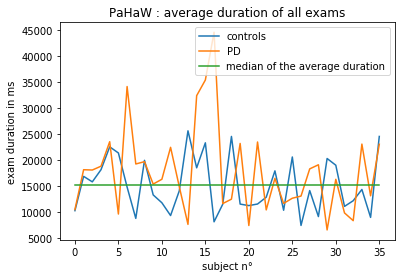

In [8]:
plt.title("PaHaW : average duration of all exams")
plt.plot(np.mean(control_time,axis=1),label="controls")
plt.plot(np.mean(patients_time,axis=1),label="PD")
plt.plot([median for _ in range(36)],label="median of the average duration")
plt.xlabel("subject n°")
plt.ylabel("exam duration in ms")
plt.legend()

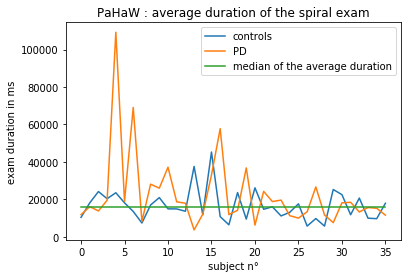

In [9]:
plt.title("PaHaW : average duration of the spiral exam")
plt.plot(control_time[:,0],label="controls")
plt.plot(patients_time[:,0],label="PD")
plt.plot([medians[0] for _ in range(36)],label="median of the average duration")
plt.xlabel("subject n°")
plt.ylabel("exam duration in ms")
plt.legend()

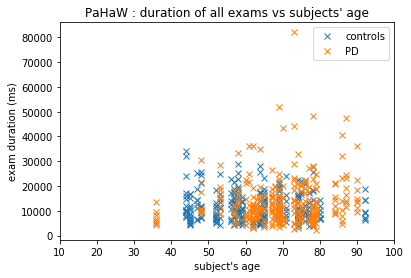

In [296]:
plt.title("PaHaW : duration of all exams vs subjects' age")
plt.xlabel("subject's age")
plt.xlim(10,100)
plt.ylabel("exam duration (ms)")
plt.plot(control_ages*8,flat_list(control_time),'x',label="controls")
plt.plot(patients_ages*8,flat_list(patients_time),'x',label="PD")
plt.legend()

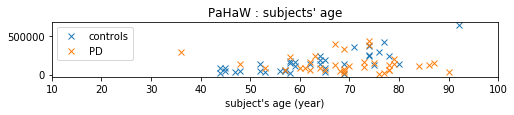

In [16]:
plt.figure(figsize=(8,1))
plt.title("PaHaW : subjects' age")
plt.plot(control_ages,[np.random.rand()*i**3 for i in control_ages],'x',label="controls")
plt.plot(patients_ages,[np.random.rand()*i**3 for i in control_ages],'x',label="PD")
plt.xlim(10,100)
#plt.ylim(-1,2)
plt.xlabel("subject's age (year)")
plt.legend()

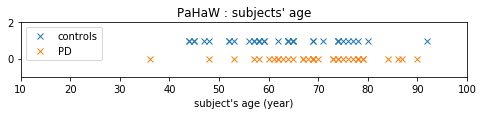

In [10]:
plt.figure(figsize=(8,1))
plt.title("PaHaW : subjects' age")
plt.plot(control_ages,[1 for _ in control_ages],'x',label="controls")
plt.plot(patients_ages,[0 for _ in control_ages],'x',label="PD")
plt.xlim(10,100)
plt.ylim(-1,2)
plt.xlabel("subject's age (year)")
plt.legend()

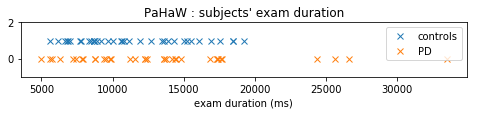

In [17]:
plt.figure(figsize=(8,1))
plt.title("PaHaW : subjects' exam duration")
plt.plot(np.mean(control_time,axis=1),[1 for _ in control_ages],'x',label="controls")
plt.plot(np.mean(patients_time,axis=1),[0 for _ in control_ages],'x',label="PD")
#plt.xlim(10,100)
plt.ylim(-1,2)
plt.xlabel("exam duration (ms)")
plt.legend()

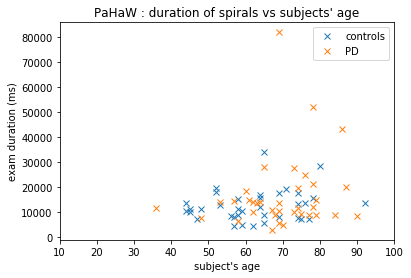

In [398]:
plt.title("PaHaW : duration of spirals vs subjects' age")
plt.xlabel("subject's age")
plt.xlim(10,100)
plt.ylabel("exam duration (ms)")
plt.plot(control_ages,control_time[:,0],'x',label="controls")
plt.plot(patients_ages,patients_time[:,0],'x',label="PD")
plt.legend()

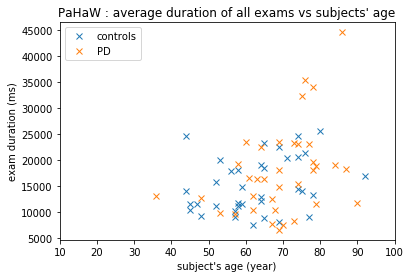

In [12]:
plt.title("PaHaW : average duration of all exams vs subjects' age")
plt.xlabel("subject's age (year)")
plt.xlim(10,100)
plt.ylabel("exam duration (ms)")
plt.plot(control_ages,np.mean(control_time,axis=1),'x',label="controls")
plt.plot(patients_ages,np.mean(patients_time,axis=1),'x',label="PD")
plt.legend()

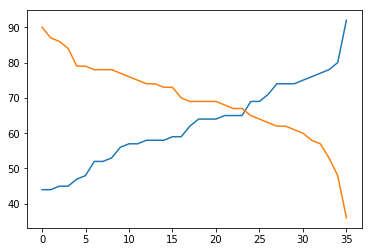

In [9]:

plt.plot(sorted(control_ages))
plt.plot(sorted(patients_ages,reverse=True))

# Exploration

Provides some insights about the content of the data

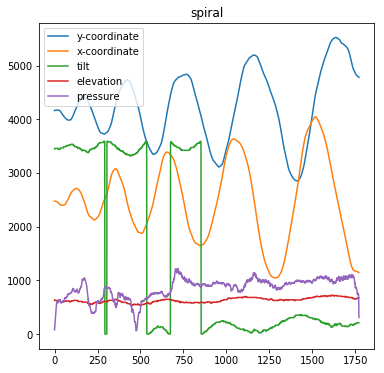

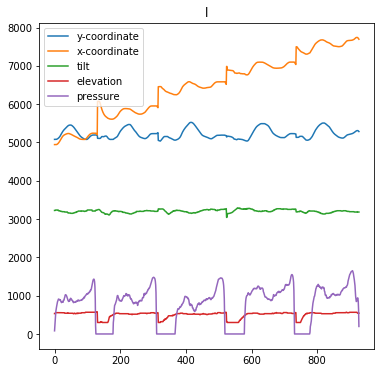

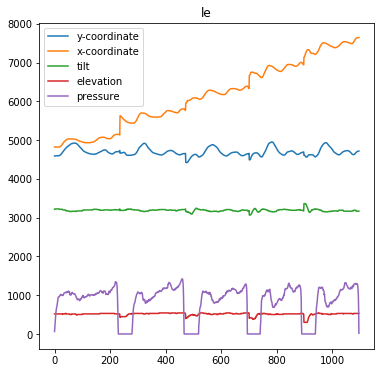

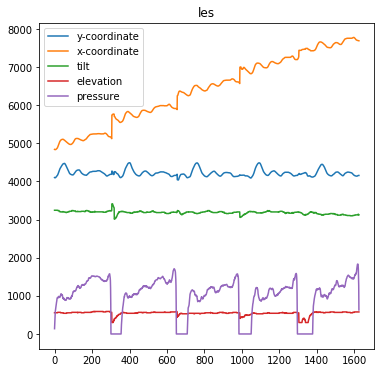

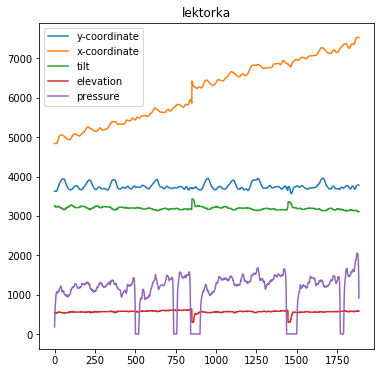

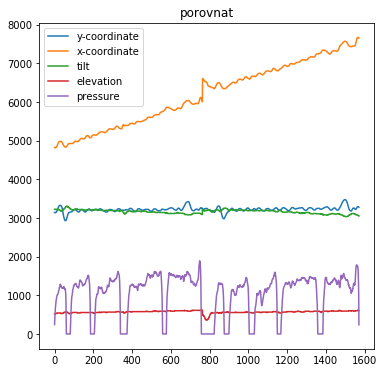

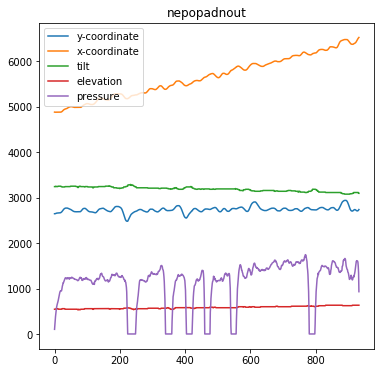

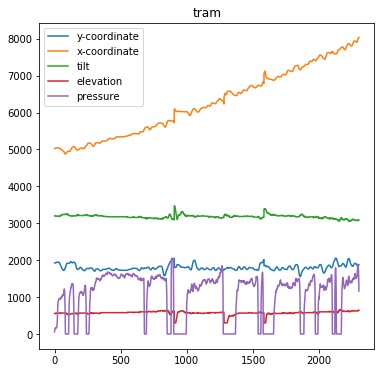

In [8]:
%matplotlib inline
subject_index=0#np.random.randint(0,len(labels))
for j in range(8):
    task=np.asarray(data[subject_index][j])
    plt.figure(figsize=(6,6))
    plt.title(index2task[j])
    for i in [0,1,4,5,6]:
        plt.plot(task[:,i],label=index2measure[i])
        plt.legend()
    

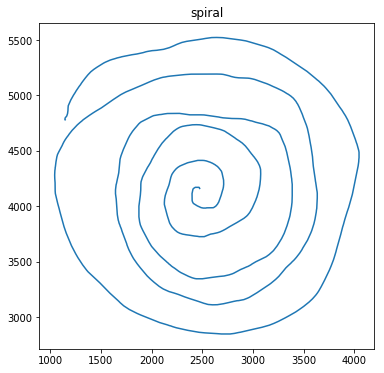

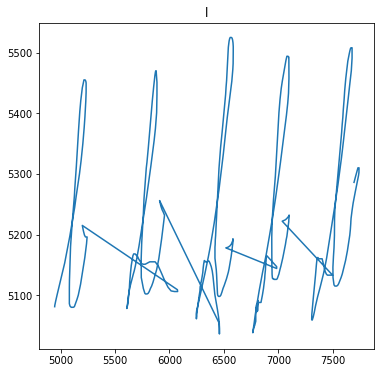

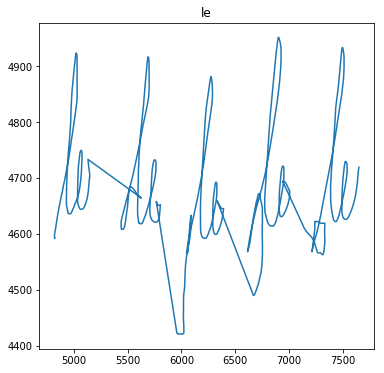

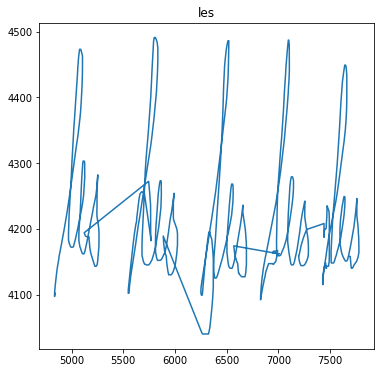

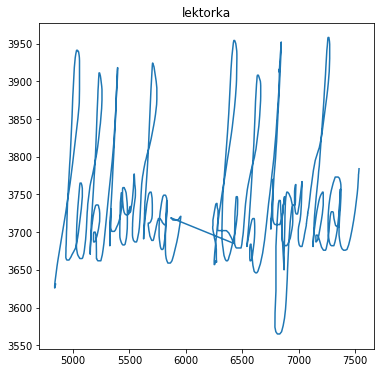

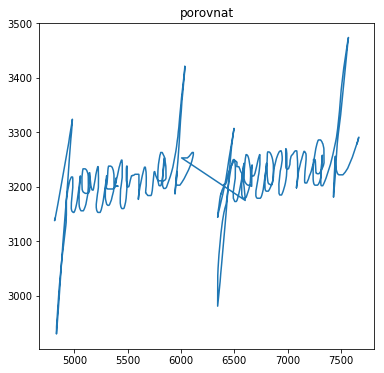

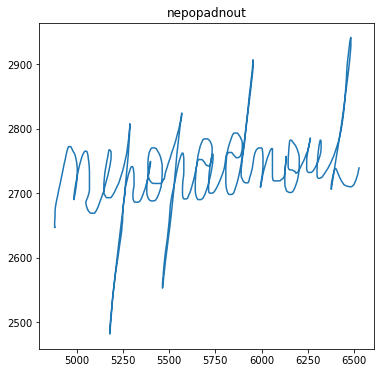

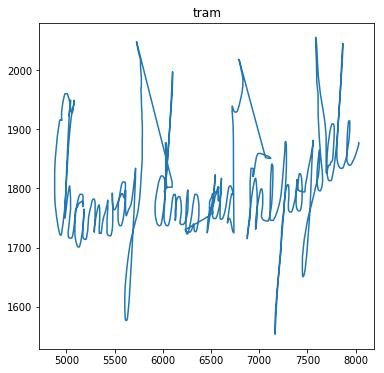

In [10]:
%matplotlib inline
subject_index=0#np.random.randint(0,len(labels))
for j in range(8):
    task=np.asarray(data[subject_index][j])
    plt.figure(figsize=(6,6))
    plt.title(index2task[j])
    plt.plot(task[:,1],task[:,0])

In [17]:
def DetectPause(time):
    """looks through the difference between 2 consecutives points of the timestamp of a task
    to detect if there's pauses during the recording
    
    Returns :
    - True if a Pause was detected
    - False if not"""
    timediff = [time[t+1]-time[t] for t in range(len(time)-1)]
    #print(timediff)
    for t in timediff:
        if t!=7 and t!=8:
            return True
    return False

In [18]:
patients_pause=0
controls_pause=0
for i in range(72):
    for j in range(7):
        if DetectPause(data[i][j][:,2]):
            if targets[i]==1:
                patients_pause+=1
            else:
                controls_pause+=1

In [19]:
patients_pause,controls_pause

(238, 236)

After investigation I found that most of the exams contained (really) small pauses.  
Therefore, the timestamp measure might be useful so the model has a sense of these pauses.  

## Recording errors
These recording errors are now corrected in the load_data function as explained in [Loading](#Loading)

All the subject’s numbers I mention are counting from
zero and after excluding the subjects that didn’t perform the
spiral exam.
### Exam starting in air

The exams spiral, l, lektorka and tram from subjects 56,
9, 39 and 67, respectively, started their exam while pen was
in air (i.e. not on paper). Although Drotar et al. say that the recording
starts when the pen first touches the paper so I assume it’s a
recording error and discarded the in-air points.

In [11]:
in_air=[(i,j,targets[i])  for j,_ in enumerate(subject) for i,subject in enumerate(data) if data[i][j][0][3] != 1]
print(in_air)

[(56, 0, 0), (9, 1, 1), (39, 4, 0), (67, 7, 0)]


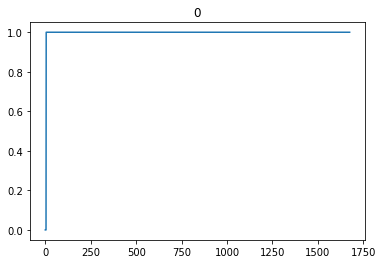

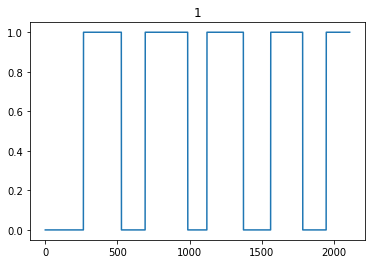

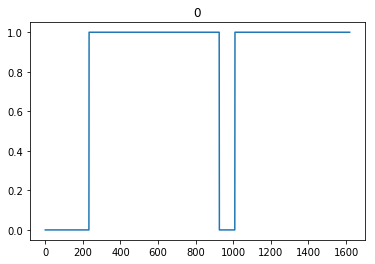

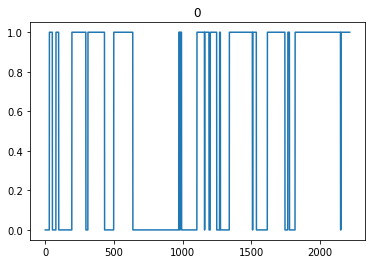

In [12]:
for i,j,p in [(i,j,targets[i])  for j,_ in enumerate(subject) for i,subject in enumerate(data) if data[i][j][0][3] != 1]:
    task=np.asarray(data[i][j])
    plt.figure()
    plt.title(p)
    plt.plot(task[:,3])

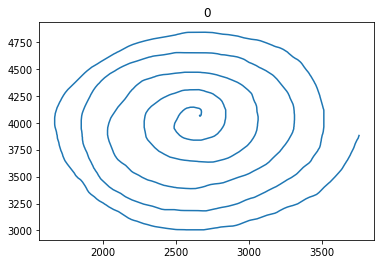

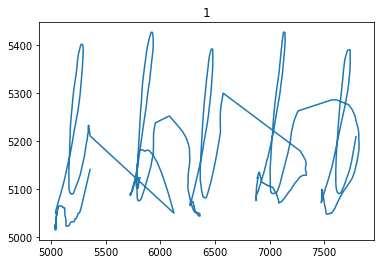

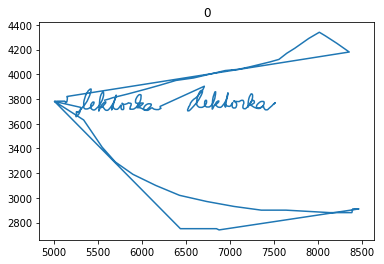

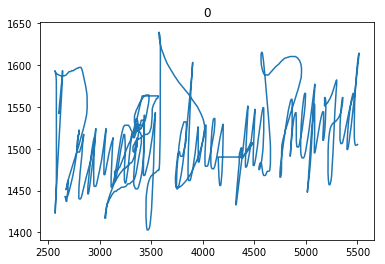

In [13]:
for i,j,p in [(i,j,targets[i])  for j,_ in enumerate(subject) for i,subject in enumerate(data) if data[i][j][0][3] != 1]:
    task=np.asarray(data[i][j])
    plt.figure()
    plt.title(p)
    plt.plot(task[:,1],task[:,0])

### Exam finishing in air
In the same way the subject # 43 has a recording problem
on his tram exam : the timestamp measure jumps to 10<sup>12</sup> on
the 12 last points of the recording although the timestamps
from all subjects are in the 10<sup>6</sup> magnitude. So I assume it’s
a recording error and discarded the 12 last points.

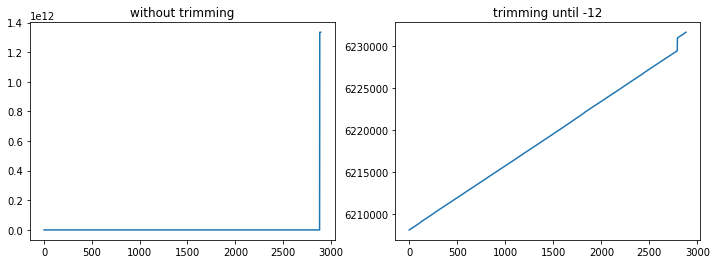

In [281]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title("without trimming")
plt.plot(np.array(data[43][-1])[:,2])
plt.subplot(122)
plt.title("trimming until -12")
plt.plot(np.array(data[43][-1])[:-12,2])

## Preprocessing


### Standardize
along axis 0 in order to normalize all the measures independently (i.e. not all time steps independently)  
Cf. Report #4 : it's better to standardize than to normalize !

0


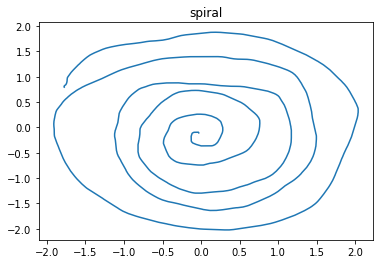

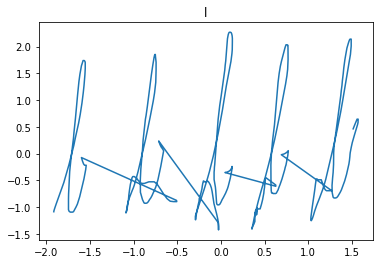

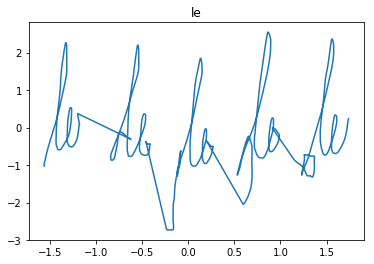

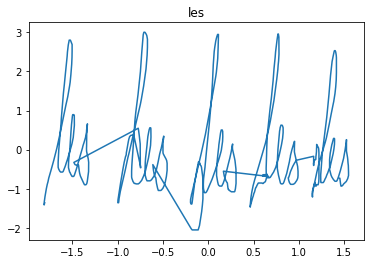

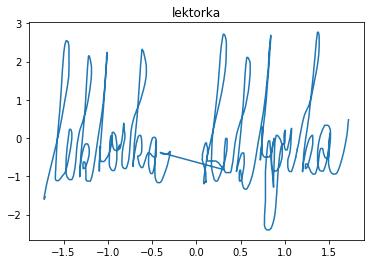

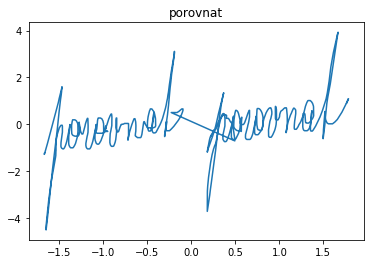

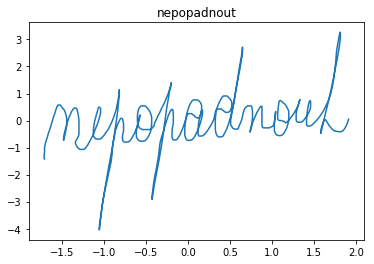

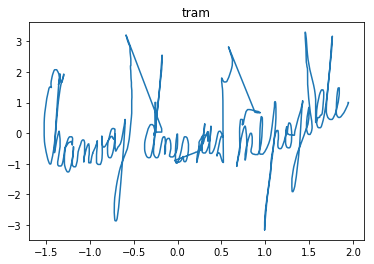

In [15]:
%matplotlib inline
subject_index=0#np.random.randint(0,len(labels))
print(subject_index)
for j in range(8):
    task=scale(np.asarray(data[subject_index][j]),axis=0)
    if task.size!=0:
        plt.figure()
        plt.title(index2task[j])
        plt.plot(task[:,1],task[:,0])
    else:
        print("Subject n° {} didn't perform {} task".format(subject_index,index2task[j]))

### Dowsampling
downsamples using [SciPy's decimate](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.decimate.html).  
After experiment [SciPy's resample](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html) is ineffective as the signal is not periodic

In [ ]:
The tasks 0, 1, 4, and 7 from subjects 56, 9, 39 and 67, respectively, started their exam while pen was in air (i.e. not on paper). All these subjects are control except for n° 9.


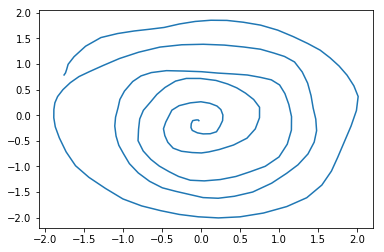

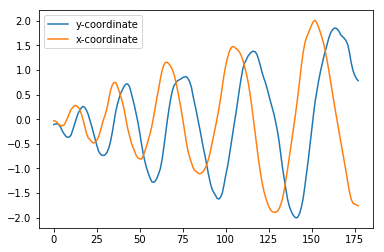

In [16]:
downsampling_factor=10#the sequence will be 10 times shorter !
task=scale(np.asarray(data[0][0]),axis=0)
sparse_spiral=decimate(task,downsampling_factor,axis=0)
%matplotlib inline
plt.figure()
plt.plot(sparse_spiral[:,1],sparse_spiral[:,0])
plt.figure()
for i in [0,1]:
    plt.plot(sparse_spiral[:,i],label=index2measure[i])
    plt.legend()
